In [1]:
import os
import sys
import cv2
import time
import copy
import timeit
import random
import pathlib
import logging
import numpy as np
import albumentations
from tqdm import tqdm
from functools import partial

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from models.segformer import Segformer
from utils.runners import testval
from utils.label_utils import get_labels
from utils.modelsummary import get_model_summary
from utils.data_utils import label_mapping, SegmentationDataset, display_blend, cityscapes_label_to_rgb
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d)

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
transforms_training = ComposeDouble([
    FunctionWrapperDouble(random_resize, scale_factor=16, base_size=cfg.DATASET.BASE_SIZE[1], both=True),
    FunctionWrapperDouble(random_crop, crop_size=cfg.DATASET.CROP_SIZE, 
                          ignore_label=cfg.DATASET.IGNORE_LABEL, both=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(random_brightness, input=True, target=False),
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])


transforms_validation = ComposeDouble([
    FunctionWrapperDouble(random_crop, crop_size=cfg.DATASET.CROP_SIZE, 
                          ignore_label=cfg.DATASET.IGNORE_LABEL, both=True),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])


transforms_inference = ComposeDouble([
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])

In [3]:
train_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "train", transform = transforms_training)
valid_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_validation)
infer_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_inference)

train_dataloader = DataLoader(
    dataset = train_dataset, 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True
)
valid_dataloader = DataLoader(
    dataset = valid_dataset, 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True
)
infer_dataloader = DataLoader(
    dataset = infer_dataset, 
    batch_size = 1, 
    shuffle = True
)

x, y, _, names = next(iter(train_dataloader))
xv, yv, _, vnames = next(iter(valid_dataloader))
xi, yi, _, inames = next(iter(infer_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

Images: 2975 , Labels: 2975
Images: 500 , Labels: 500
Images: 500 , Labels: 500
x.shape: (2, 3, 1024, 1024), x.type: torch.float32, [min(x), max(x)]: [-2.015, 2.640]
y.shape: (2, 1024, 1024), y.type: torch.int64 
y unique: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 13, 17, 18, 255]


In [4]:
def sliding_window(im, crop_size, stride):
    B, C, H, W = im.shape
    cs = crop_size

    windows = {"crop": [], "anchors": []}
    h_anchors = np.arange(0, H, stride[0])
    w_anchors = np.arange(0, W, stride[1])
    
    h_anchors = [h.item() for h in h_anchors if h < H - cs[0]] + [H - cs[0]]
    w_anchors = [w.item() for w in w_anchors if w < W - cs[1]] + [W - cs[1]]
    for ha in h_anchors:
        for wa in w_anchors:
            window = im[:, :, ha : ha + cs[0], wa : wa + cs[1]]
            windows["crop"].append(window)
            windows["anchors"].append((ha, wa))
    windows["shape"] = (H, W)
    return windows


def display_blend_windows(display_list):
    plt.figure(figsize=(15, 10), dpi=150)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(2, 3, i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
def merge_windows(windows, crop_size, ori_shape):
    cs = crop_size
    im_windows = windows["crop_seg"]
    anchors = windows["anchors"]
    C = im_windows[0].shape[1]
    H, W = windows["shape"]
    
    logit = np.zeros((C, H, W))
    count = np.zeros((1, H, W))
    for window, (ha, wa) in zip(im_windows, anchors):
        # print("window.shape: {}, (ha, wa): ({}, {})".format(window.shape, ha, wa))
        logit[:, ha : ha + cs[0], wa : wa + cs[1]] += window.squeeze()
        count[:, ha : ha + cs[0], wa : wa + cs[1]] += 1
        
    logit = logit / count
    logit = F.interpolate(torch.from_numpy(logit).unsqueeze(0), ori_shape, mode="bilinear")[0]

    result = F.softmax(logit, 0)
    
    return result.numpy()


def sliding_inference(model, image):
    # assume input image is channels first
    batch, _, ori_height, ori_width = image.size()
    assert batch == 1, "only supporting batchsize 1."
    
    # gather sliding windows 
    windows = sliding_window(im=image, crop_size=cfg.DATASET.CROP_SIZE, stride=(1024, 1024)) 
    crop_list = windows['crop']
    # print([crop.size() for crop in crop_list])
    
    # make predictions on windows
    pred_list = []
    for x_crop in crop_list:
        pred = model(x_crop.to(device))
        pred = F.interpolate(pred, cfg.DATASET.CROP_SIZE, mode="bilinear", align_corners=False)        
        pred_list.append(pred.detach().numpy())
            
    windows['crop_seg'] = pred_list
    pred = merge_windows(windows, crop_size=cfg.DATASET.CROP_SIZE, ori_shape=cfg.DATASET.BASE_SIZE)
    return np.exp(pred)

In [5]:
SEG_CFG = cfg.MODEL.B2

model = Segformer(
    pretrained = None, # SEG_CFG.PRETRAINED,
    img_size = cfg.DATASET.CROP_SIZE[0], 
    patch_size = cfg.MODEL.PATCH_SIZE, 
    embed_dims = SEG_CFG.CHANNEL_DIMS, 
    num_heads = SEG_CFG.NUM_HEADS, 
    mlp_ratios = SEG_CFG.MLP_RATIOS,
    qkv_bias = SEG_CFG.QKV_BIAS, 
    depths = SEG_CFG.DEPTHS, 
    sr_ratios = SEG_CFG.SR_RATIOS,
    drop_rate = SEG_CFG.DROP_RATE, 
    drop_path_rate = SEG_CFG.DROP_PATH_RATE,
    decoder_dim = SEG_CFG.DECODER_DIM,
    norm_layer = partial(nn.LayerNorm, eps=1e-6), 
).to(device)

model.load_state_dict(torch.load("weights/segformer_b2_best.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
model.eval()
pred = sliding_inference(model, xi)
pred = np.argmax(pred, axis=0)

/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


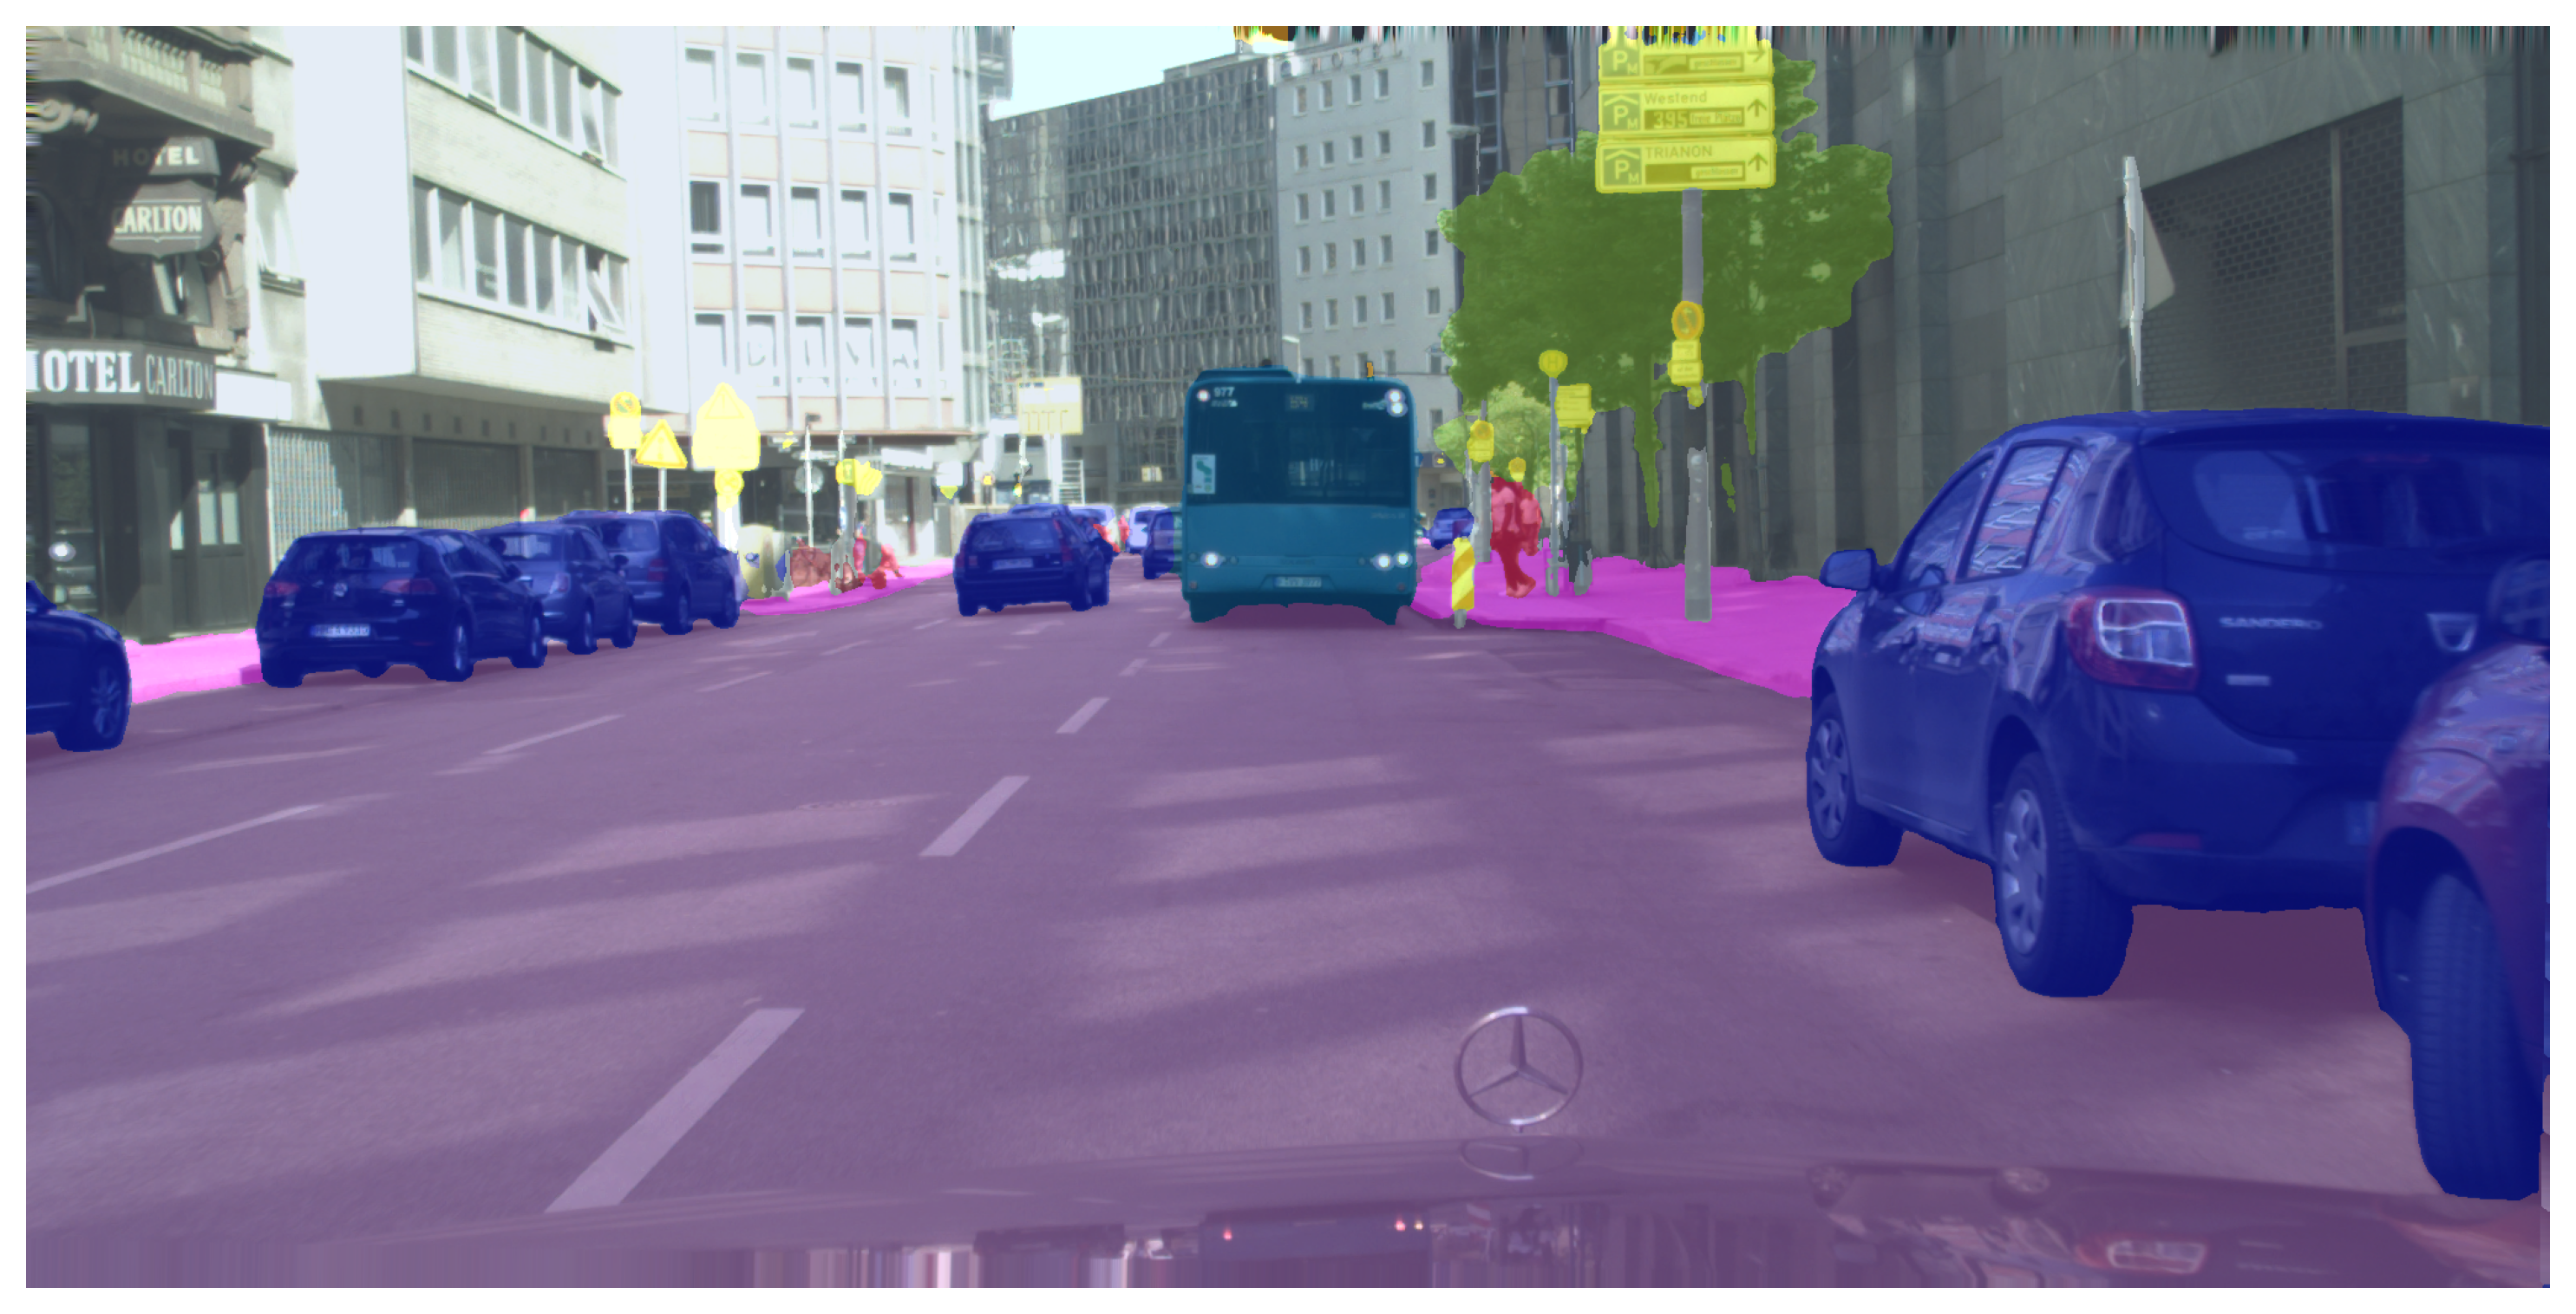

In [7]:
display_blend([
    [re_normalize(xi[0].permute(1,2,0).numpy()), cityscapes_label_to_rgb(pred)]
])

In [8]:
mean_IoU, IoU_array, pixel_acc, mean_acc = testval(
    cfg, 
    infer_dataloader, 
    model, 
    sv_dir=cfg.OUTPUT_DIR, 
    sv_pred=True,
    sliding_inf=True
)

 26%|██▌       | 128/500 [1:24:56<4:06:51, 39.82s/it]


KeyboardInterrupt: 

In [ ]:
print("Mean IoU: {:.3f}, Mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))